In [ ]:
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

In [2]:
sns.set_theme(style='whitegrid')

plt.rcParams.update({
    'figure.figsize': (8, 4.5),
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 11,
    'axes.labelweight': 'normal',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'patch.edgecolor': 'black',
    'patch.linewidth': 1,
    'legend.frameon': False,
    'legend.fontsize': 9,
    'legend.title_fontsize': 10,
    'figure.subplot.right': 0.75
})

sns.set_palette(['#4C72B0', '#DD8452'])

In [ ]:
warnings.filterwarnings('ignore', category=FutureWarning)

pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_columns', None)

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

In [4]:
read_path = os.path.join(BASE_DIR, 'data', 'raw_medical_appointment_data.csv')
df = pd.read_csv(read_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   PatientId                110527 non-null  float64
 1   AppointmentID            110527 non-null  int64  
 2   Gender                   110527 non-null  object 
 3   ScheduledDay             110527 non-null  object 
 4   AppointmentDay           110527 non-null  object 
 5   Age                      110527 non-null  int64  
 6   Neighbourhood            110527 non-null  object 
 7   Scholarship              110527 non-null  int64  
 8   Hipertension             110527 non-null  int64  
 9   Diabetes                 110527 non-null  int64  
 10  Alcoholism               110527 non-null  int64  
 11  Handcap                  110527 non-null  int64  
 12  SMS_received             110527 non-null  int64  
 13  No-show                  110527 non-null  object 
 14  appo

In [5]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,appointment_day_of_week,appointment_month,day_difference,previous_no_shows
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,4,4,-1,-1
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,4,4,-1,-1
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,4,4,-1,-1
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,4,4,-1,-1
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,4,4,-1,-1


In [6]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.rename(columns={'PatientId':'patient_id', 'AppointmentID':'appointment_id', 'Gender':'gender', 'ScheduledDay':'scheduled_day', 
                     'AppointmentDay':'appointment_day', 'Age':'age', 'Neighbourhood':'neighborhood', 'Scholarship':'scholarship', 
                     'Hipertension':'hypertension', 'Diabetes':'diabetes', 'Alcoholism':'alcoholism', 'Handcap':'handicap', 
                     'SMS_received':'sms_received', 'No-show':'no_show'}, inplace=True)

In [8]:
# Convert patient_id to string because it's an identifier required for later aggregation
df['patient_id'] = df['patient_id'].astype(str)

# Remove appointment_id because it's not needed for our purposes
df.set_index('appointment_id', drop=True, inplace=True)

In [9]:
df['gender'] = df['gender'].replace({'M': 'male', 'F': 'female'})
df['gender'].value_counts()

gender
female    71840
male      38687
Name: count, dtype: int64

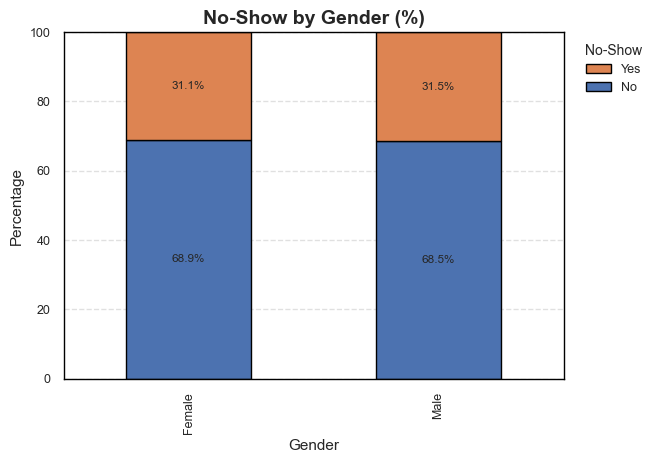

In [ ]:
proportions = df.groupby(['gender', 'no_show']).size().unstack(fill_value=0)
proportions = proportions.div(proportions.sum(axis=1), axis=0) * 100

ax = proportions.plot(kind='bar', stacked=True)

plt.title('No-Show by Gender (%)')
plt.xlabel('Gender')
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'])
plt.ylabel('Percentage')
plt.ylim(0, 100)

for idx, gender in enumerate(proportions.index):
    bottom = 0
    for val in proportions.loc[gender]:
        plt.text(idx, bottom + val/2, f'{val:.1f}%', ha='center', va='center', fontsize=8.5)
        bottom += val

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.02, 1), loc='upper left', title='No-Show')

plt.show()

In [11]:
df['scheduled_day'] = pd.to_datetime(df['scheduled_day'])
df['appointment_day'] = pd.to_datetime(df['appointment_day'])

In [12]:
# Extract appointment day of the week as additional feature for training
df['appointment_day_of_week'] = df['appointment_day'].dt.weekday.astype('int64')
df['appointment_day_of_week'].value_counts().rename({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).dropna().astype('int64')

appointment_day_of_week
Monday       22715
Tuesday      25640
Wednesday    25867
Thursday     17247
Friday       19019
Saturday        39
Name: count, dtype: int64

In [13]:
# Drop Saturday appointments due to extremely low frequency and potential noise
df = df[(df['appointment_day_of_week'] != 5)]

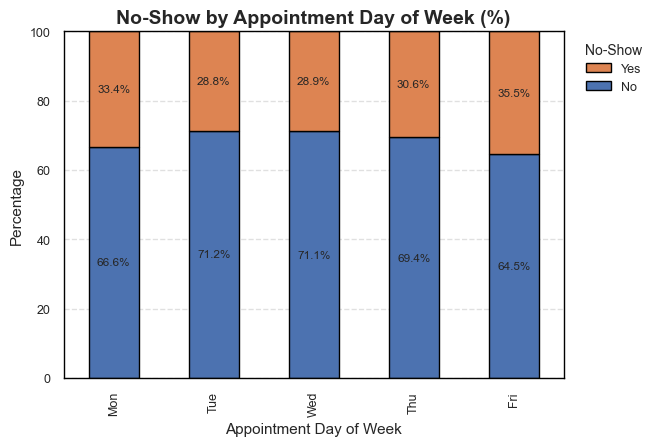

In [14]:
proportions = df.groupby(['appointment_day_of_week', 'no_show']).size().unstack(fill_value=0)
proportions = proportions.div(proportions.sum(axis=1), axis=0) * 100

ax = proportions.plot(kind='bar', stacked=True)

plt.title('No-Show by Appointment Day of Week (%)')
plt.xticks(ticks = [0, 1, 2, 3, 4, ], labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
plt.xlabel('Appointment Day of Week')
plt.ylabel('Percentage')
plt.ylim(0, 100)

for idx, appointment_day_of_week in enumerate(proportions.index):
    bottom = 0
    for val in proportions.loc[appointment_day_of_week]:
        plt.text(idx, bottom + val/2, f'{val:.1f}%', ha='center', va='center', fontsize=8.5)
        bottom += val

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.02, 1), loc='upper left', title='No-Show')

plt.show()

In [15]:
# Extract appointment month as additional feature for training
df['appointment_month'] = df['appointment_day'].dt.month.astype('int64')
df['appointment_month'].value_counts().rename({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}).reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']).dropna().astype('int64')

appointment_month
April     3235
May      80802
June     26451
Name: count, dtype: int64

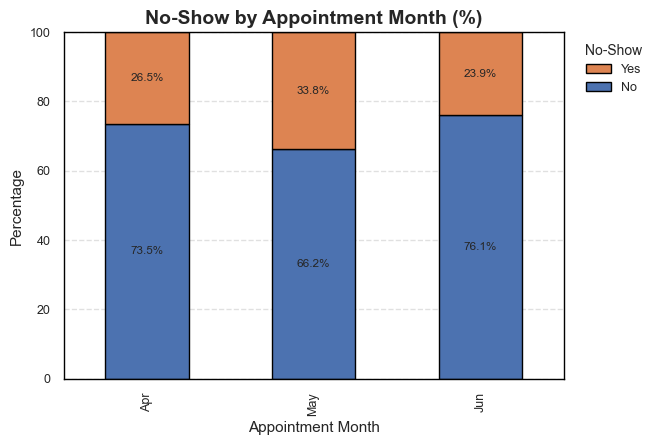

In [ ]:
proportions = df.groupby(['appointment_month', 'no_show']).size().unstack(fill_value=0)
proportions = proportions.div(proportions.sum(axis=1), axis=0) * 100

ax = proportions.plot(kind='bar', stacked=True)

plt.title('No-Show by Appointment Month (%)')
plt.xticks(ticks=[0, 1, 2], labels=['Apr', 'May', 'Jun'])
plt.xlabel('Appointment Month')
plt.ylabel('Percentage')
plt.ylim(0, 100)

for idx, appointment_month in enumerate(proportions.index):
    bottom = 0
    for val in proportions.loc[appointment_month]:
       plt.text(idx, bottom + val/2, f'{val:.1f}%', ha='center', va='center', fontsize=8.5)
       bottom += val

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.02, 1), loc='upper left', title='No-Show')

plt.show()

In [ ]:
# Calculate difference in scheduling and appointment days as additional feature for training
df['scheduled_day'] = df['scheduled_day'].dt.date
df['appointment_day'] = df['appointment_day'].dt.date
df['day_difference'] = (df['appointment_day'] - df['scheduled_day']).apply(lambda x : x.days).astype('int64')
df['day_difference'].describe().round(2)

count    110488.00
mean         10.19
std          15.26
min          -6.00
25%           0.00
50%           4.00
75%          15.00
max         179.00
Name: day_difference, dtype: float64

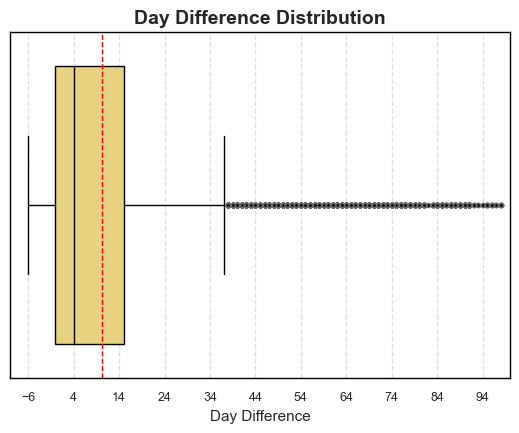

In [ ]:
sns.boxplot(
   x=df['day_difference'], 
   color='#F7DC6F',
   boxprops=dict(edgecolor='black'), 
   whiskerprops=dict(color='black'),  
   capprops=dict(color='black'),       
   medianprops=dict(color='black'),   
   flierprops=dict(markerfacecolor='black', marker='o', markersize=3)
)

plt.title('Day Difference Distribution')
plt.xlabel('Day Difference')
plt.xticks(np.arange(df['day_difference'].min(), min(df['day_difference'].max() + 1, 101), 10))
plt.xlim(-10, 100) 
plt.yticks([])
plt.axvline(df['day_difference'].mean(), color='red', linestyle='--', linewidth=1)

plt.show()

In [19]:
# Inspect appointments with negative day_difference (appointment scheduled after it occurred)
df[df['day_difference'] < 0]

,patient_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,appointment_day_of_week,appointment_month,day_difference,previous_no_shows
appointment_id,,,,,,,,,,,,,,,,,
5679978,7839272661752.0,male,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,0,5,-1,0
5715660,7896293967868.0,female,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,1,5,-1,1
5664962,24252258389979.0,female,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,2,5,-1,1
5686628,998231581612122.0,female,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,3,5,-6,1
5655637,3787481966821.0,male,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,1,5,-1,0


In [20]:
# Drop such appointments as invalid entries
df = df[df['day_difference'] >= 0]

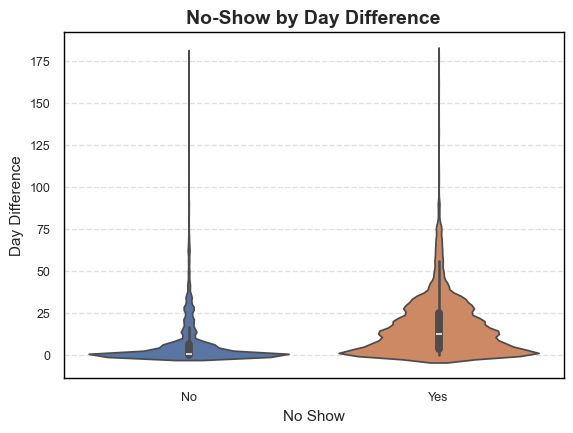

In [ ]:
sns.violinplot(x='no_show', y='day_difference', data=df, palette=['#4C72B0', '#DD8452'])

plt.title('No-Show by Day Difference')
plt.xlabel('No Show')
plt.ylabel('Day Difference')
plt.xticks(ticks=[0, 1])

plt.show()

In [22]:
df['age'].describe().round(2)

count    110483.00
mean         37.08
std          23.11
min          -1.00
25%          18.00
50%          37.00
75%          55.00
max         115.00
Name: age, dtype: float64

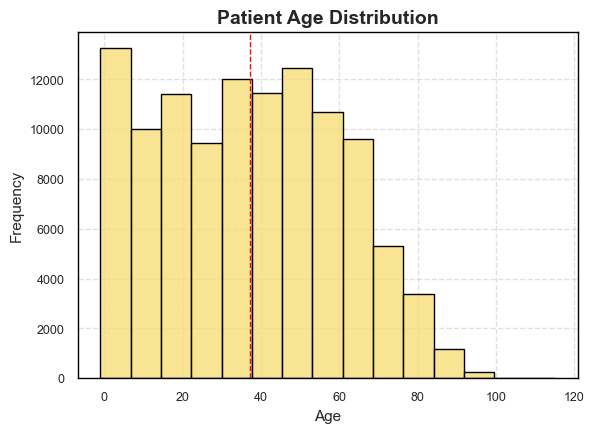

In [ ]:
sns.histplot(df['age'], bins=15, color='#F7DC6F')

plt.title('Patient Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.axvline(df['age'].mean(), color='red', linestyle='--', linewidth=1)

plt.show()

In [24]:
df[df['age'] < 0]

,patient_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,appointment_day_of_week,appointment_month,day_difference,previous_no_shows
appointment_id,,,,,,,,,,,,,,,,,
5775010,465943158731293.0,female,2016-06-06,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,No,0,6,0,-1


In [25]:
df = df[df['age'] >= 0]

In [26]:
df['neighborhood'] = df['neighborhood'].str.title()
df['neighborhood'].unique()

array(['Jardim Da Penha', 'Mata Da Praia', 'Pontal De Camburi',
       'República', 'Goiabeiras', 'Andorinhas', 'Conquista',
       'Nova Palestina', 'Da Penha', 'Tabuazeiro', 'Bento Ferreira',
       'São Pedro', 'Santa Martha', 'São Cristóvão', 'Maruípe',
       'Grande Vitória', 'São Benedito', 'Ilha Das Caieiras',
       'Santo André', 'Solon Borges', 'Bonfim', 'Jardim Camburi',
       'Maria Ortiz', 'Jabour', 'Antônio Honório', 'Resistência',
       'Ilha De Santa Maria', 'Jucutuquara', 'Monte Belo',
       'Mário Cypreste', 'Santo Antônio', 'Bela Vista', 'Praia Do Suá',
       'Santa Helena', 'Itararé', 'Inhanguetá', 'Universitário',
       'São José', 'Redenção', 'Santa Clara', 'Centro', 'Parque Moscoso',
       'Do Moscoso', 'Santos Dumont', 'Caratoíra', 'Ariovaldo Favalessa',
       'Ilha Do Frade', 'Gurigica', 'Joana D´Arc', 'Consolação',
       'Praia Do Canto', 'Boa Vista', 'Morada De Camburi', 'Santa Luíza',
       'Santa Lúcia', 'Barro Vermelho', 'Estrelinha', 'Forte São 

In [27]:
print('Top 5 Neighborhoods by Appointment Count')
top_neighborhoods = df['neighborhood'].value_counts().head()
for neighborhood, count in top_neighborhoods.items():
    print(f'{neighborhood}: {count}')
    
print('\nBottom 5 Neighborhoods by Appointment Count')
bottom_neighborhoods = df['neighborhood'].value_counts().tail()
for neighborhood, count in bottom_neighborhoods.items():
    print(f'{neighborhood}: {count}')

Top 5 Neighborhoods by Appointment Count
Jardim Camburi: 7717
Maria Ortiz: 5805
Resistência: 4430
Jardim Da Penha: 3877
Itararé: 3514

Bottom 5 Neighborhoods by Appointment Count
Ilha Do Boi: 35
Ilha Do Frade: 10
Aeroporto: 8
Ilhas Oceânicas De Trindade: 2
Parque Industrial: 1


In [28]:
print(df['scholarship'].value_counts().rename({0 : 'No', 1 : 'Yes'}).reindex(['Yes', 'No']).astype('int64'))

df_temp = df.assign(scholarship=df['scholarship'].map({0: 'No', 1: 'Yes'}))
(df_temp.groupby('scholarship')['no_show'].value_counts(normalize=True).unstack() * 100).round(1).T.reindex(['Yes', 'No'])[['Yes', 'No']].astype(str) + '%'

scholarship
Yes    10858
No     99624
Name: count, dtype: int64


scholarship,Yes,No
no_show,,
Yes,47.2%,29.5%
No,52.8%,70.5%


In [29]:
print(df['hypertension'].value_counts().rename({0 : 'No', 1 : 'Yes'}).reindex(['Yes', 'No']).astype('int64'))

df_temp = df.assign(hypertension=df['hypertension'].map({0: 'No', 1: 'Yes'}))
(df_temp.groupby('hypertension')['no_show'].value_counts(normalize=True).unstack() * 100).round(1).T.reindex(['Yes', 'No'])[['Yes', 'No']].astype(str) + '%'

hypertension
Yes    21782
No     88700
Name: count, dtype: int64


hypertension,Yes,No
no_show,,
Yes,26.5%,32.4%
No,73.5%,67.6%


In [30]:
print(df['diabetes'].value_counts().rename({0 : 'No', 1 : 'Yes'}).reindex(['Yes', 'No']).astype('int64'))

df_temp = df.assign(diabetes=df['diabetes'].map({0: 'No', 1: 'Yes'}))
(df_temp.groupby('diabetes')['no_show'].value_counts(normalize=True).unstack() * 100).round(1).T.reindex(['Yes', 'No'])[['Yes', 'No']].astype(str) + '%'

diabetes
Yes      7936
No     102546
Name: count, dtype: int64


diabetes,Yes,No
no_show,,
Yes,25.8%,31.6%
No,74.2%,68.4%


In [31]:
print(df['alcoholism'].value_counts().rename({0 : 'No', 1 : 'Yes'}).reindex(['Yes', 'No']).astype('int64'))

df_temp = df.assign(alcoholism=df['alcoholism'].map({0: 'No', 1: 'Yes'}))
(df_temp.groupby('alcoholism')['no_show'].value_counts(normalize=True).unstack() * 100).round(1).T.reindex(['Yes', 'No'])[['Yes', 'No']].astype(str) + '%'

alcoholism
Yes      3358
No     107124
Name: count, dtype: int64


alcoholism,Yes,No
no_show,,
Yes,28.0%,31.3%
No,72.0%,68.7%


In [32]:
print(df['handicap'].value_counts().sort_index())

(df.groupby('handicap')['no_show'].value_counts(normalize=True).unstack() * 100).round(1).T.reindex(['Yes', 'No']).astype(str) + '%'

handicap
0    108244
1      2039
2       183
3        13
4         3
Name: count, dtype: int64


handicap,0,1,2,3,4
no_show,,,,,
Yes,31.2%,28.6%,33.3%,23.1%,33.3%
No,68.8%,71.4%,66.7%,76.9%,66.7%


In [33]:
print(df['sms_received'].value_counts().rename({0 : 'No', 1 : 'Yes'}).reindex(['Yes', 'No']).astype('int64'))

sms_received
Yes    35469
No     75013
Name: count, dtype: int64


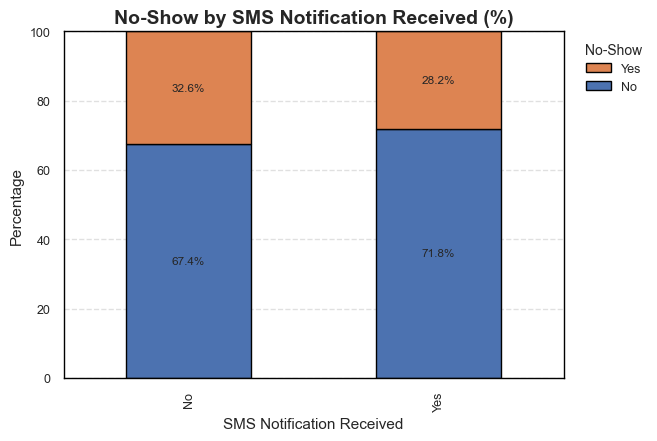

In [ ]:
proportions = df.groupby(['sms_received', 'no_show']).size().unstack(fill_value=0)
proportions = proportions.div(proportions.sum(axis=1), axis=0) * 100

ax = proportions.plot(kind='bar', stacked=True)

plt.title('No-Show by SMS Notification Received (%)')
plt.xlabel('SMS Notification Received')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.ylabel('Percentage')
plt.ylim(0, 100)

for idx, sms_received in enumerate(proportions.index):
    bottom = 0
    for val in proportions.loc[sms_received]:
        plt.text(idx, bottom + val/2, f'{val:.1f}%', ha='center', va='center', fontsize=8.5)
        bottom += val

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.02, 1), loc='upper left', title='No-Show')

plt.show()

In [35]:
print(df['no_show'].value_counts().reindex(['Yes', 'No']))
df['no_show'] = df['no_show'].replace({'Yes': 1, 'No': 0}).astype('int64')

no_show
Yes    34467
No     76015
Name: count, dtype: int64


In [ ]:
# Calculate how many previous appointments were missed as additional feature for training
df = df.sort_values(by=['patient_id', 'appointment_day'])
df['previous_no_shows'] = df.groupby('patient_id')['no_show'].transform(lambda x: x.shift(1).fillna(0).cumsum())
df['previous_no_shows'] = df['previous_no_shows'].fillna(0).astype('int64')
df['previous_no_shows'].value_counts()

previous_no_shows
0     89173
1     14328
2      3463
3      1333
4       715
5       380
6       267
7       184
8       138
9        85
10       73
11       49
12       48
13       38
14       35
15       23
16       21
17       21
18       12
19       10
20        9
21        7
22        7
23        4
24        3
25        3
26        3
27        3
28        3
35        3
30        2
31        2
32        2
29        2
33        2
34        2
36        2
37        2
38        2
39        2
40        2
41        2
50        2
42        1
44        1
43        1
46        1
47        1
48        1
45        1
49        1
51        1
52        1
53        1
54        1
55        1
56        1
57        1
Name: count, dtype: int64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110482 entries, 5715720 to 5736309
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   patient_id               110482 non-null  object
 1   gender                   110482 non-null  object
 2   scheduled_day            110482 non-null  object
 3   appointment_day          110482 non-null  object
 4   age                      110482 non-null  int64 
 5   neighborhood             110482 non-null  object
 6   scholarship              110482 non-null  int64 
 7   hypertension             110482 non-null  int64 
 8   diabetes                 110482 non-null  int64 
 9   alcoholism               110482 non-null  int64 
 10  handicap                 110482 non-null  int64 
 11  sms_received             110482 non-null  int64 
 12  no_show                  110482 non-null  int64 
 13  appointment_day_of_week  110482 non-null  int64 
 14  appointment_month 

In [ ]:
df = df.drop(columns=['patient_id', 'scheduled_day', 'appointment_day'])
df = df[['gender', 'age', 'neighborhood', 'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap',  'appointment_month', 'appointment_day_of_week', 'previous_no_shows', 'day_difference', 'sms_received', 'no_show']]

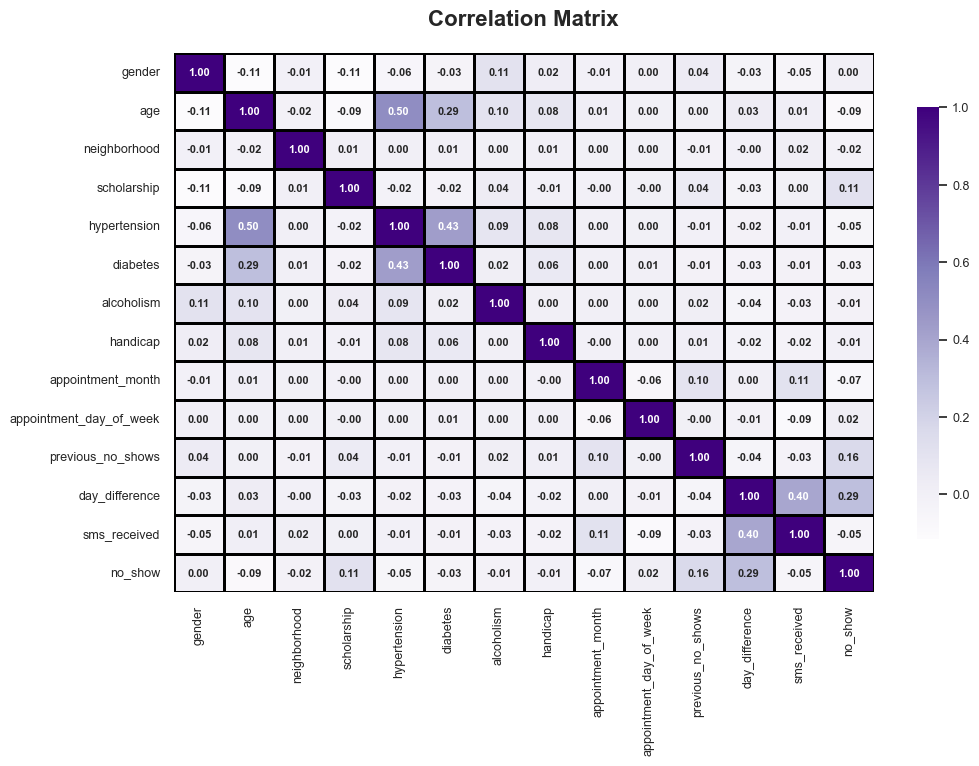

In [43]:
label_encoder = LabelEncoder()
df_corr = df.copy()

df_corr['gender'] = label_encoder.fit_transform(df_corr['gender'])
df_corr['neighborhood'] = label_encoder.fit_transform(df_corr['neighborhood'])

corr_matrix = df_corr.corr()

plt.figure(figsize=(14, 7))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='Purples',
    cbar_kws={'shrink': 0.8},
    linewidths=1,
    linecolor='black',
    annot_kws={'size': 8, 'weight': 'bold'}
)

plt.title('Correlation Matrix', fontsize=16, weight='bold', pad=20)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

In [40]:
write_path = os.path.join(BASE_DIR, 'data', 'clean_medical_appointment_data.csv')
df.to_csv(write_path, index=False)